# Find Optimal Photometry for HD163466 in Y4 filter
=============================================================================

- creation 09/07/2016
- author Sylvie Dagoret-Campagne


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

from astropy.table import Table
from astropy.table import Column

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [16]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture,CircularAnnulus
from photutils import aperture_photometry
from astropy.table import hstack
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

In [17]:
from scipy import stats 
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [18]:
import re

In [19]:
from photutils.background import Background2D

In [20]:
import libMonocamBaseImages           # my tool library written to do that CCD reduction

In [21]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-07-09 10:37:07.167891
fits date format for the analysis :  2016-07-09T10:37:07


In [22]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    weights=np.where(weights>0,weights,0)
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (average, np.sqrt(variance))

## Definitions and Constants

In [23]:
object_name='HD163466_y4'

### input files

In [24]:
path='./HD163466_y4'
rootfilename='AssScImHD163466_y4_' 
NumStart=1
NumStop=8

### output file (table)

In [25]:
outputtablefile='HD163466_y4_1-8_TablePhotometry.fits'

### make the filelist

In [26]:
filelist=libMonocamBaseImages.BuildFilelist(path,rootfilename,start=NumStart,stop=NumStop,nbchar=1)

In [27]:
filelist

['./HD163466_y4/AssScImHD163466_y4_1.fits',
 './HD163466_y4/AssScImHD163466_y4_2.fits',
 './HD163466_y4/AssScImHD163466_y4_3.fits',
 './HD163466_y4/AssScImHD163466_y4_4.fits',
 './HD163466_y4/AssScImHD163466_y4_5.fits',
 './HD163466_y4/AssScImHD163466_y4_6.fits',
 './HD163466_y4/AssScImHD163466_y4_7.fits',
 './HD163466_y4/AssScImHD163466_y4_8.fits']

In [28]:
baseobject_list=[ re.findall('./HD163466_y4/AssScIm(HD163466_y4_[0-9]+).fits',file)[0] for file in filelist]

In [29]:
baseobject_list

['HD163466_y4_1',
 'HD163466_y4_2',
 'HD163466_y4_3',
 'HD163466_y4_4',
 'HD163466_y4_5',
 'HD163466_y4_6',
 'HD163466_y4_7',
 'HD163466_y4_8']

In [30]:
NBFILES=len(filelist)

## Read Input files

In [31]:
allchannelallsciimages = []  # list of 16 lists of images series 
exposures_list = []        # sequential list of the exposures of the sky flats 
header_list = []           # list of headers
data_list = []
time_list = []                # date and time
basefile_list = []         # basefilename
dateobs_list = [] 
# get the primary block headers:
for image_file in filelist: 
    print image_file
    hdu_list = fits.open(image_file)
    basefile_list.append(os.path.basename(image_file))
    header=hdu_list[0].header
    exposure=header['EXPOSURE']
    exposures_list.append(exposure)
    dateobs_list.append(header['DATE-OBS'])
    header_list.append(header)
    data=ccdproc.CCDData.read(image_file, hdu=0,unit='adu') 
    data_list.append(data)

./HD163466_y4/AssScImHD163466_y4_1.fits
./HD163466_y4/AssScImHD163466_y4_2.fits
./HD163466_y4/AssScImHD163466_y4_3.fits
./HD163466_y4/AssScImHD163466_y4_4.fits
./HD163466_y4/AssScImHD163466_y4_5.fits
./HD163466_y4/AssScImHD163466_y4_6.fits
./HD163466_y4/AssScImHD163466_y4_7.fits
./HD163466_y4/AssScImHD163466_y4_8.fits


In [32]:
#basefile_list

## For control

uncomment for control

In [33]:
index=0

In [34]:
#print exposures_list[index]

In [35]:
#header_list[index]

In [36]:
#plt.imshow(data_list[index])

In [37]:
#bkg= Background2D(data_list[index], (100, 100), filter_size=(3, 3),method='median')

In [38]:
#data_list[index].data-bkg.background

## Background subtraction

In [39]:
correctedimage_list = []

In [40]:
for idx,data in enumerate(data_list):
    bkg= Background2D(data, (100, 100), filter_size=(3, 3),method='median')
    newimage=(data-bkg.background)/exposures_list[idx]   # normalize photometry per second
    correctedimage_list.append(newimage)

## Cut into small  images

In [41]:
NBIMAGES=len(correctedimage_list)

In [42]:
wpix=200

In [43]:
star2D_list = []
position_list = []
sigmapix_list = []
sigmaxpix_list = []
sigmaypix_list = []
sigmax_psf_list = []
sigmay_psf_list = []



In [44]:
# loop on images
for idx,image in enumerate(correctedimage_list):
    (y0,x0)=np.where(image == image.max())
    print 'star',idx,' at (x0,y0) =',x0,',',y0
    # cut the image
    the_star2D=image[y0-wpix:y0+wpix,x0-wpix:x0+wpix]
    # put image in list for photometry
    star2D_list.append(the_star2D)
    # project the PSF on both axis
    thepsfX=the_star2D.sum(axis=0)
    thepsfY=the_star2D.sum(axis=1)
    # save the psf
    sigmax_psf_list.append(thepsfX)
    sigmay_psf_list.append(thepsfY)
    # calculate sigmax and sigmay
    (mx,sigx)=weighted_avg_and_std(np.arange(thepsfX.shape[0]),thepsfX)
    (my,sigy)=weighted_avg_and_std(np.arange(thepsfY.shape[0]),thepsfY)
    # save position and sigmax and sigmay for photometry
    position_list.append((my,mx))
    sigmapix_list.append((sigy,sigx))
    sigmaxpix_list.append(sigx)
    sigmaypix_list.append(sigy)
    

star 0  at (x0,y0) = [2104] , [1880]
star 1  at (x0,y0) = [2103] , [1880]
star 2  at (x0,y0) = [2103] , [1880]


/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


star 3  at (x0,y0) = [2104] , [1879]
star 4  at (x0,y0) = [2104] , [1879]
star 5  at (x0,y0) = [2103] , [1879]
star 6  at (x0,y0) = [2104] , [1880]
star 7  at (x0,y0) = [2103] , [1880]


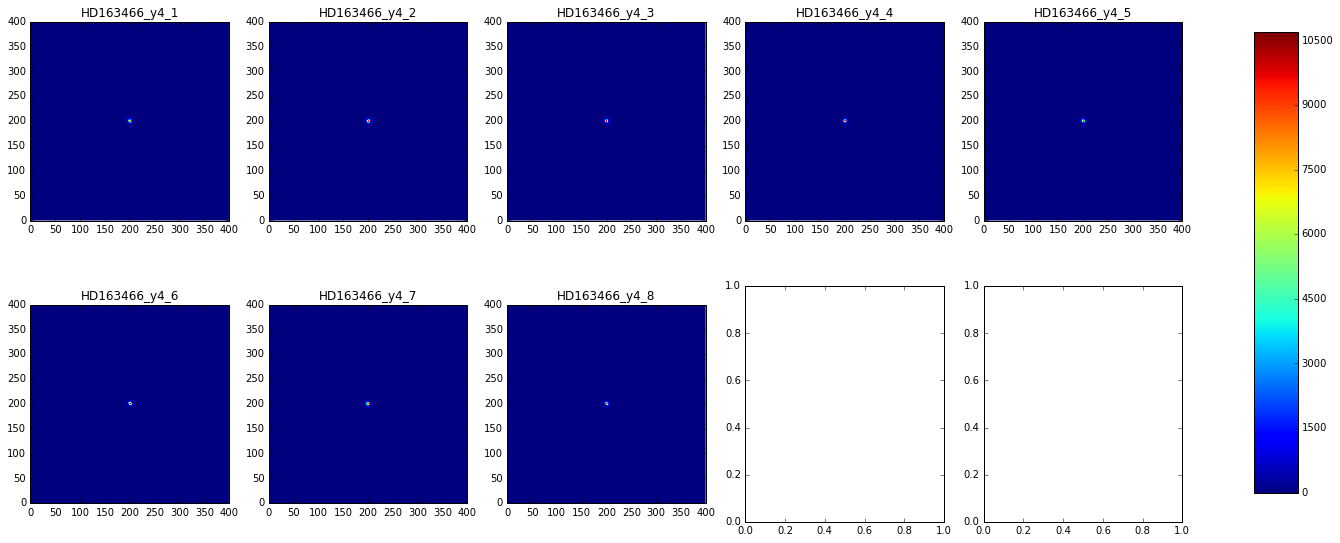

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(20,8)
# Plot kernels
for i in range(2):
    for j in range(5):
        index=5*i+j
        if index <NBFILES :
            image_title=re.findall('./HD163466_y4/AssScIm(HD163466_y4_[0-9]+).fits',filelist[index])[0]
            im = axes[i, j].imshow(star2D_list[index],interpolation='None',origin='lower')
            axes[i, j].set_title(image_title)
			
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
plt.colorbar(im, cax=cax)
plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05)
plt.show()

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


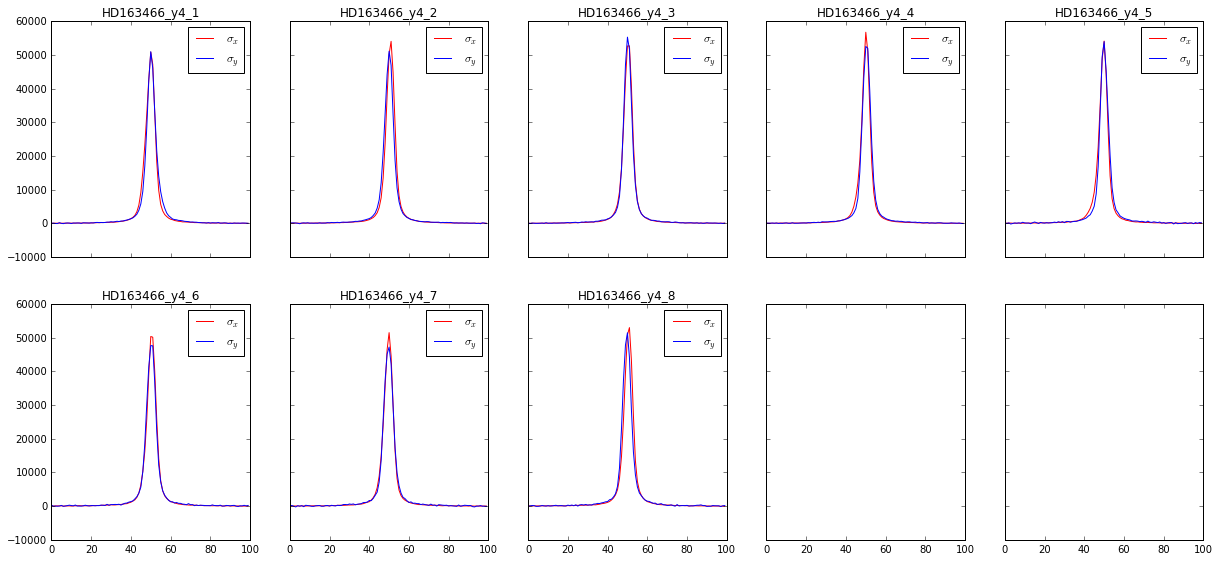

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=5,sharex=True,sharey=True)
fig.set_size_inches(20,8)
# Plot kernels
for i in range(2):
    for j in range(5):
        index=5*i+j
        if index <NBFILES :
            image_title=re.findall('./HD163466_y4/AssScIm(HD163466_y4_[0-9]+).fits',filelist[index])[0]
            axes[i, j].plot(sigmax_psf_list[index][150:250],color='r',label='$\sigma_x$')
            axes[i, j].plot(sigmay_psf_list[index][150:250],color='b',label='$\sigma_y$')
            axes[i, j].set_title(image_title)
            axes[i, j].legend()

plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05)
plt.legend()
plt.show()

## Compute photometry

In [47]:
phot_table_list = []
aperture_sum_raw_list = []
aperture_sum_bkg_list = []
residual_aperture_sum_list = []


In [48]:
for idx,star_im in enumerate(star2D_list):

    print '========================================================='    
    print 'photometry for image ',idx
    print '========================================================='  
    
    the_sigmapix=max(sigmapix_list[idx])
    the_position=position_list[idx]
    
    star_aperture=CircularAperture(the_position, 3*the_sigmapix)
    rawflux_table = aperture_photometry(star_im, star_aperture)
    
    annulus_apertures = CircularAnnulus(the_position, r_in=5*the_sigmapix, r_out=7*the_sigmapix)
    bkgflux_table = aperture_photometry(star_im, annulus_apertures)
    
    phot_table = hstack([rawflux_table, bkgflux_table], table_names=['raw', 'bkg'])
    
    bkg_mean = phot_table['aperture_sum_bkg'] / annulus_apertures.area()
    
    bkg_sum = bkg_mean * star_aperture.area()
    final_sum = phot_table['aperture_sum_raw'] - bkg_sum
    phot_table['residual_aperture_sum'] = final_sum
    print(phot_table['residual_aperture_sum']) 
    
    aperture_sum_raw_list.append(phot_table['aperture_sum_raw'][0])
    aperture_sum_bkg_list.append(phot_table['aperture_sum_bkg'][0])
    residual_aperture_sum_list.append(phot_table['residual_aperture_sum'][0])
    
    phot_table_list.append(phot_table)
    
    
    

photometry for image  0
residual_aperture_sum
                     
---------------------
        331203.543016
photometry for image  1
residual_aperture_sum
                     
---------------------
        331676.399966
photometry for image  2
residual_aperture_sum
                     
---------------------
        333006.225881
photometry for image  3
residual_aperture_sum
                     
---------------------
        332105.307971
photometry for image  4
residual_aperture_sum
                     
---------------------
        330511.590305
photometry for image  5
residual_aperture_sum
                     
---------------------
        330070.477506
photometry for image  6
residual_aperture_sum
                     
---------------------
        329431.754753
photometry for image  7
residual_aperture_sum
                     
---------------------
         330572.68775


In [49]:
print phot_table_list[0]

aperture_sum_raw xcenter_raw [1] ... ycenter_bkg [1] residual_aperture_sum
                                 ...                                      
---------------- --------------- ... --------------- ---------------------
   331132.031009   200.467413433 ...   199.214043518         331203.543016


In [50]:
phot_table_list[1]

aperture_sum_raw,xcenter_raw [1],ycenter_raw [1],aperture_sum_bkg,xcenter_bkg [1],ycenter_bkg [1],residual_aperture_sum
,,,,,,
float64,float64,float64,float64,float64,float64,float64
331672.076267,199.978755261,200.173002956,-11.5298636609,199.978755261,200.173002956,331676.399966


## Create astropy table

In [51]:
#t=Table(rows=image_psf,names=('num','nbstars','prfx','pfry','sig_prfx','sig_prfy'),dtype=('i4','i4','f8','f8','f8','f8'))

In [52]:
t=Table()

In [53]:
t

<Table length=0>
<No columns>

In [54]:
obj= Column(baseobject_list,name='object')
expo = Column(exposures_list, name='exposure')
time = Column(dateobs_list,name='time')
sigma_x =Column(sigmaxpix_list,name='sigmaxpix_psf')
sigma_y =Column(sigmaypix_list,name='sigmaypix_psf')
aperture_sum_raw= Column( aperture_sum_raw_list  ,name='aperture_sum_raw')
aperture_sum_bkg= Column( aperture_sum_bkg_list  ,name='aperture_sum_bkg')
residual_aperture_sum=Column(residual_aperture_sum_list, name='residual_aperture_sum')



In [55]:
t.add_column(obj, index=0)
t.add_column(time, index=1)
t.add_column(expo, index=2)
t.add_column(sigma_x,index=3)
t.add_column(sigma_y,index=4)
t.add_column(aperture_sum_raw,index=5)
t.add_column(aperture_sum_bkg,index=6)
t.add_column(residual_aperture_sum,index=7)

In [56]:
t

object,time,exposure,sigmaxpix_psf,sigmaypix_psf,aperture_sum_raw,aperture_sum_bkg,residual_aperture_sum
str13,str23,float64,float64,float64,float64,float64,float64
HD163466_y4_1,2016-05-10T08:43:22.192,3.0,10.4658929282,19.2605276496,331132.031009,-190.698687132,331203.543016
HD163466_y4_2,2016-05-10T08:43:29.513,3.0,11.0911947628,20.2395561092,331672.076267,-11.5298636609,331676.399966
HD163466_y4_3,2016-05-10T08:43:36.463,3.0,10.8619903442,20.4493313042,332841.863375,-438.30001571,333006.225881
HD163466_y4_4,2016-05-10T08:43:43.448,3.0,10.732116767,21.5112413197,331770.139652,-893.782184476,332105.307971
HD163466_y4_5,2016-05-10T08:44:47.481,1.5,15.4422979959,26.8799001579,330442.389195,-184.536292493,330511.590305
HD163466_y4_6,2016-05-10T08:44:52.918,1.5,15.3230621605,28.6909667127,329727.557361,-914.453719723,330070.477506
HD163466_y4_7,2016-05-10T08:44:58.453,1.5,14.3215314708,27.781936465,329412.592851,-51.0984062257,329431.754753
HD163466_y4_8,2016-05-10T08:45:04.001,1.5,12.7529880686,26.7669287309,330080.054068,-1313.68981691,330572.68775


## Write output file

In [57]:
t.write(outputtablefile,format='fits')

## Pandas

In [58]:
df=t.to_pandas()

In [59]:
df.describe()

,exposure,sigmaxpix_psf,sigmaypix_psf,aperture_sum_raw,aperture_sum_bkg,residual_aperture_sum
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,2.250000,12.623884,23.947549,330884.837972,-499.761123,331072.248394
std,0.801784,2.131961,3.921381,1173.809317,482.261668,1161.795472
min,1.500000,10.465893,19.260528,329412.592851,-1313.689817,329431.754753
25%,1.500000,10.829522,20.396888,329991.929892,-898.950068,330401.312105
50%,2.250000,11.922091,24.139085,330787.210102,-314.499351,330888.115383
75%,3.000000,14.571914,27.105409,331696.592114,-151.176821,331783.626967
max,3.000000,15.442298,28.690967,332841.863375,-11.529864,333006.225881
